Number of outliers removed: 815
          Method  Train MAE  Validation MAE
0    IQR Removal   0.113926        0.352802
1  Log Transform   0.526311        0.533231


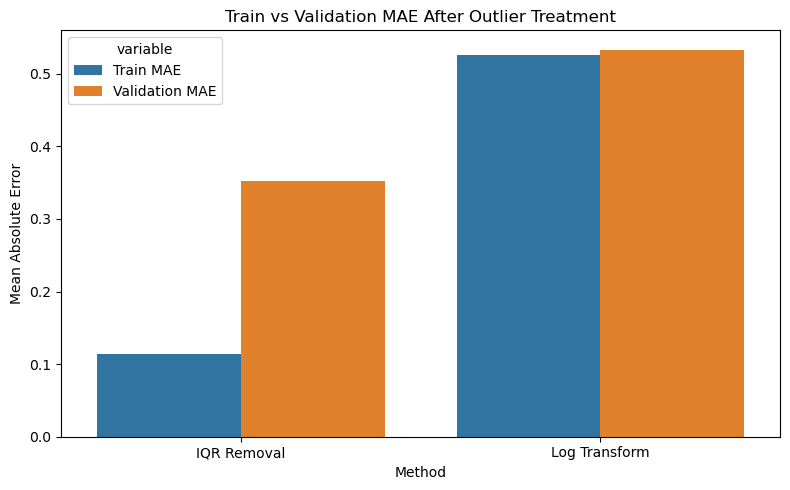

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

# Train-test split
X = df.drop(columns='Target')
y = df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

# === IQR Outlier Removal ===
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
mask = (y_train >= lower) & (y_train <= upper)

# Count and print number of outliers
num_outliers = (~mask).sum()
print(f"Number of outliers removed: {num_outliers}")

# Train with outliers removed
X_train_iqr, y_train_iqr = X_train[mask], y_train[mask]
rf_iqr = RandomForestRegressor(random_state=0)
rf_iqr.fit(X_train_iqr, y_train_iqr)
mae_train_iqr = mean_absolute_error(y_train_iqr, rf_iqr.predict(X_train_iqr))
mae_val_iqr = mean_absolute_error(y_val, rf_iqr.predict(X_val))

# === Log Transform ===
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_train_log = np.expm1(lr.predict(X_train))
y_pred_val_log = np.expm1(lr.predict(X_val))
mae_train_log = mean_absolute_error(y_train, y_pred_train_log)
mae_val_log = mean_absolute_error(y_val, y_pred_val_log)

# === Results ===
results_df = pd.DataFrame({
    'Method': ['IQR Removal', 'Log Transform'],
    'Train MAE': [mae_train_iqr, mae_train_log],
    'Validation MAE': [mae_val_iqr, mae_val_log]
})
print(results_df)

# === Plot ===
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.melt(id_vars="Method"), x="Method", y="value", hue="variable")
plt.title("Train vs Validation MAE After Outlier Treatment")
plt.ylabel("Mean Absolute Error")
plt.tight_layout()
plt.show()
